Estratégia: https://www.projectpro.io/article/speech-emotion-recognition-project-using-machine-learning/573#mcetoc_1i4jlb94qo

Dataset: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio

In [1]:
from IPython.display import Audio, display
import librosa
import matplotlib.pyplot as plt

In [2]:
audio_file_path = "dataset/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav"

sample_rate = 16000
MAX_LENGTH = 3*sample_rate  # 3 seconds

display(Audio(filename=audio_file_path, rate=sample_rate))

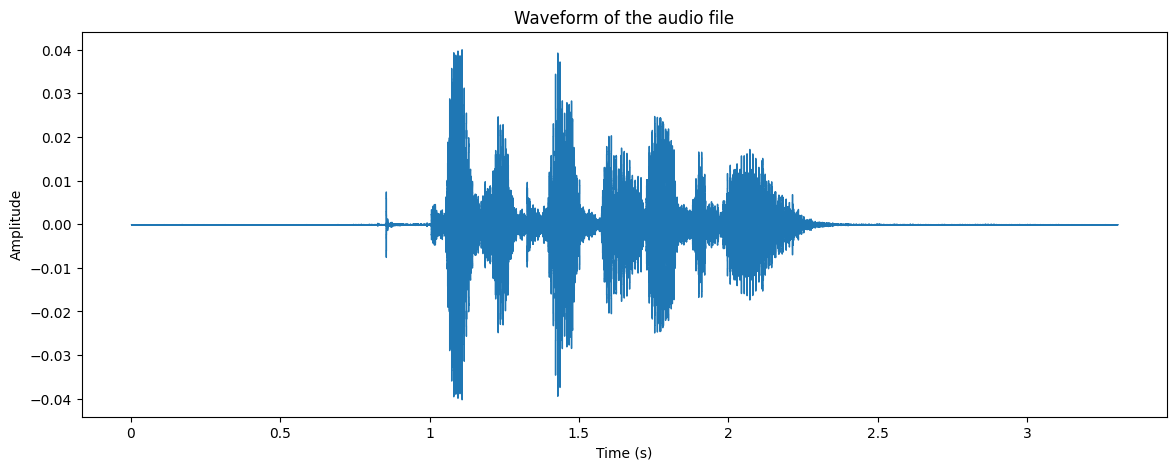

In [3]:
y, sr = librosa.load(audio_file_path, sr=sample_rate)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of the audio file')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Using CNN

In [11]:
import os
import numpy as np
import librosa # type: ignore
import joblib

mfcc_loaded = False

def extract_mfcc(file_path, sample_rate=16000, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=sample_rate, res_type='kaiser_fast')
    y = librosa.util.fix_length(y, size=MAX_LENGTH)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    
    return mfccs_mean


# Try importing previously saved MFCC features
try:
    mfcc_features = joblib.load("MFCC_features/mfcc_features.pkl")
    print("Successfully loaded MFCC features.")
    mfcc_loaded = True
except FileNotFoundError:
    print("MFCC features not found, extracting from audio files.")

if not mfcc_loaded:
    dataset_path = "dataset/ravdess-emotional-speech-audio/"
    mfcc_features = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                try:
                    file_path = os.path.join(root, file)
                    mfcc = extract_mfcc(file_path)
                    file_class = int(file[7:8]) - 1
                    mfcc_features.append((mfcc, file_class))
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    continue

    print(f"Extracted {len(mfcc_features)} files.")
    for i in range(5):
        print(mfcc_features[i])


Successfully loaded MFCC features.


In [5]:
# Save the features to a file

import joblib
if not mfcc_loaded:
    X, y = zip(*mfcc_features)
    X = np.array(X)
    y = np.array(y)

    SAVE_DIR_PATH = "MFCC_features"

    # Create directory if it doesn't exist
    os.makedirs(SAVE_DIR_PATH, exist_ok=True)

    joblib.dump((X, y), os.path.join(SAVE_DIR_PATH, 'mfcc_features.pkl'))

    print(f"MFCC features saved to {os.path.join(SAVE_DIR_PATH, 'mfcc_features.pkl')}")
    mfcc_features = (X, y)

In [6]:
# CNN

from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Activation
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

model = Sequential()
model.add(Conv1D(64, 5, padding="same", input_shape=(40, 1)))
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(8)) # 8 emotion classes
model.add(Activation("softmax"))

model.summary()

2025-10-31 20:10:38.700854: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 20:10:38.733119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-31 20:10:39.444104: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/luusamp/gits/speech-emotion-recognition/venv/lib/python3.13/site-packages/keras/src/l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        20,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,872 (81.53 KB)

 Trainable params: 20,872 (81.53 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Data splitting


X, y = mfcc_features


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_traincnn = X_train[..., np.newaxis]
X_testcnn = X_test[..., np.newaxis]

print(X_traincnn.shape, X_testcnn.shape)

(2304, 40, 1) (576, 40, 1)


In [8]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_traincnn, y_train, epochs=100, batch_size=32, validation_data=(X_testcnn, y_test), verbose=0)

# evaluation
y_pred = model.predict(X_testcnn)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))

2025-10-31 20:10:40.843278: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f6e90007240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-31 20:10:40.843298: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-10-31 20:10:40.861517: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-31 20:10:40.916565: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1761952242.281504  573619 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        38
           1       0.87      0.93      0.90        76
           2       1.00      0.38      0.55        77
           3       0.75      0.79      0.77        77
           4       0.83      0.81      0.82        77
           5       0.74      0.71      0.73        77
           6       0.77      0.66      0.71        77
           7       0.53      0.91      0.67        77

    accuracy                           0.74       576
   macro avg       0.78      0.74      0.74       576
weighted avg       0.78      0.74      0.74       576

[[28  4  0  4  2  0  0  0]
 [ 3 71  0  0  0  0  0  2]
 [ 1  1 29  4  4 12  2 24]
 [ 4  0  0 61  2  3  6  1]
 [ 0  1  0  1 62  0  4  9]
 [ 1  0  0  6  1 55  2 12]
 [ 1  5  0  3  1  3 51 13]
 [ 0  0  0  2  3  1  1 70]]


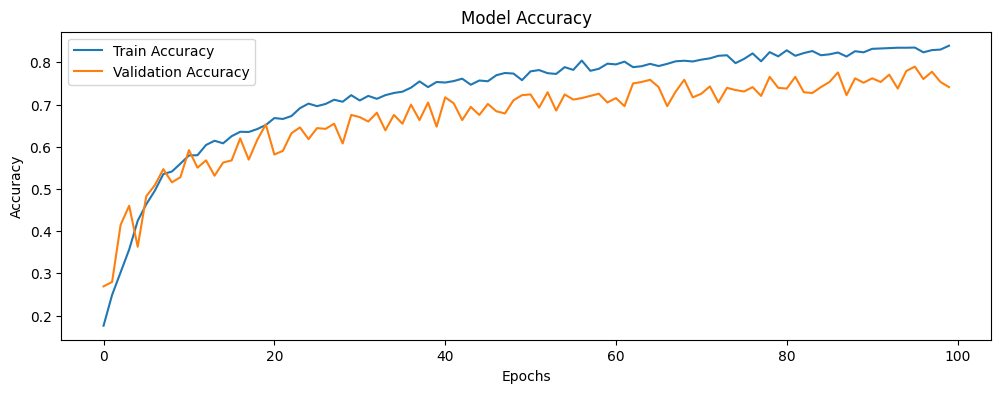

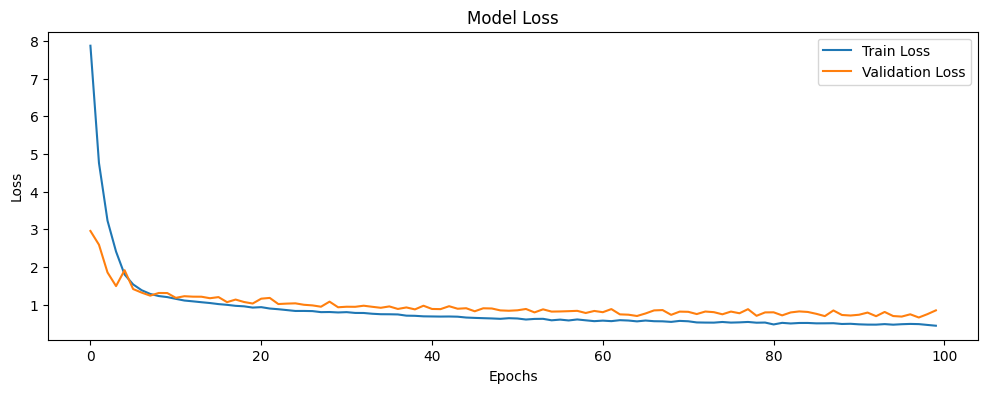

In [9]:
# Plots

# Accuracy plot
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
model.save("cnn-ravness-mfcc.keras")